In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

In [ ]:
print(customers.isnull().sum())
print(transactions.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [ ]:
print(customers.describe())
print(transactions.describe())

       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


**Data Preprocessing**

In [ ]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], format="%Y-%m-%d")
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], format="%d-%m-%Y %H:%M")

In [ ]:
current_date = pd.Timestamp("2025-01-01")
customers['Tenure'] = (current_date - customers['SignupDate']).dt.days

**Feature Engineering**

In [ ]:
transaction_features = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count']
}).reset_index()
transaction_features.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'TransactionCount']

In [ ]:
data = pd.merge(customers, transaction_features, on='CustomerID', how='inner')

In [ ]:
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

In [ ]:
features = ['Tenure', 'TotalSpending', 'AvgTransactionValue', 'TransactionCount'] + [col for col in data.columns if 'Region' in col]

**Standardizing Data**

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

**Elbow Method**

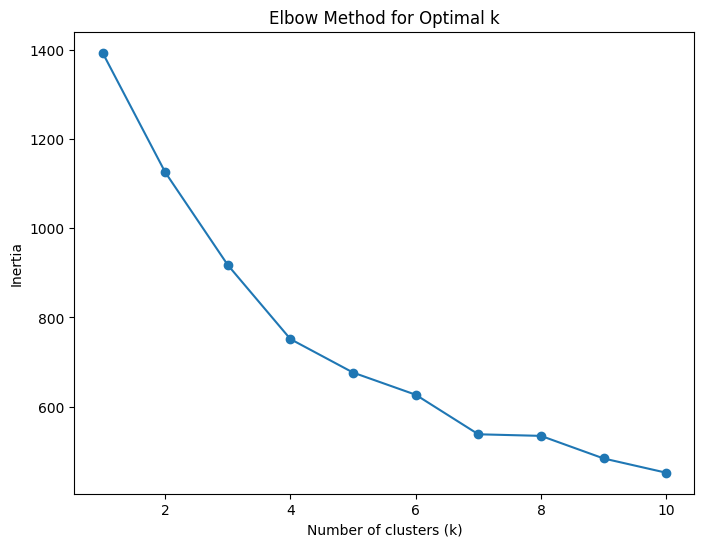

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

**K-Means clustering**

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
db_index = davies_bouldin_score(scaled_features, data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.3045404057450758


**Silhouette Score**

In [ ]:
silhouette_avg = silhouette_score(scaled_features, data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.2473786286328609


**Visualizing cluster distribution**

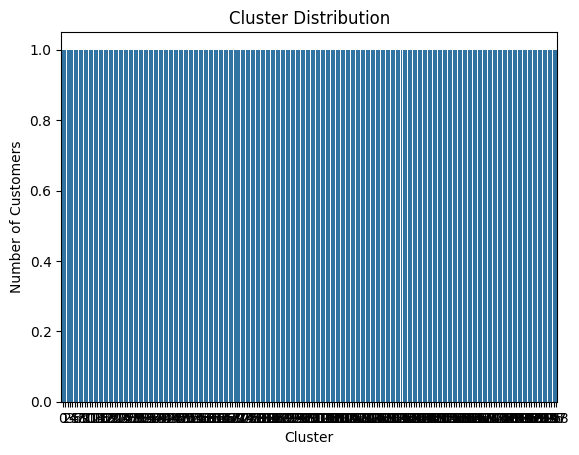

In [ ]:
sns.countplot(data['Cluster'])
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


**Visualization of PCA**

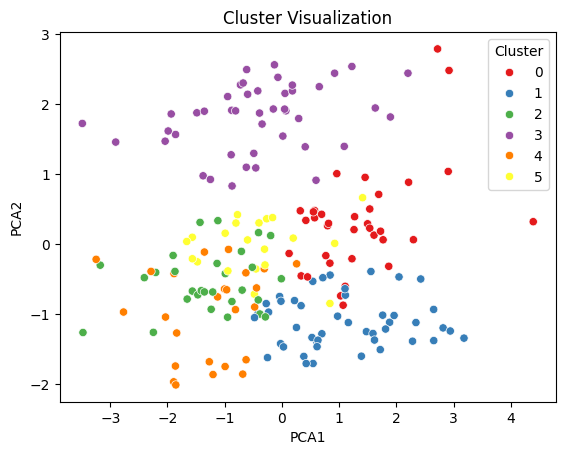

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Plotting of clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='Set1')
plt.title('Cluster Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()